In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])



In [37]:
basepath = Path("/scratch/crobin/earthnet2023_interpolated/")
train_paths = list(basepath.glob("train/*/*.nc"))
test_paths = list(basepath.glob("test/*/*.nc")) #list(basepath.glob("test/*/*.nc"))
pred_paths = list(Path("/Net/Groups/BGI/scratch/crobin/PythonProjects/EarthNet/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_interpolation_anomalie/preds/iid").glob("*/*"))
print("len train set: ", len(train_paths))
print("len test set: ", len(test_paths))
print("len prediction set: ", len(pred_paths))

len train set:  0
len test set:  100
len prediction set:  100


In [38]:
pred_path = pred_paths[80]
print(pred_path)
name = str(pred_path)[-12:]
test_path = list(basepath.glob("test/*/" + name))[0]
print(test_path)


/Net/Groups/BGI/scratch/crobin/PythonProjects/EarthNet/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_interpolation_anomalie/preds/iid/Algeria/31SEV6375.nc
/scratch/crobin/earthnet2023_interpolated/test/Algeria/31SEV6375.nc


In [6]:
name = "31SEA1934.nc"
test_path = list(basepath.glob("test/*/" + name))[0]
pred_path = list(Path("/Net/Groups/BGI/scratch/crobin/PythonProjects/EarthNet/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_anomalie_preprocessed/preds/iid").glob("*/" + name))[0]


RGB plots

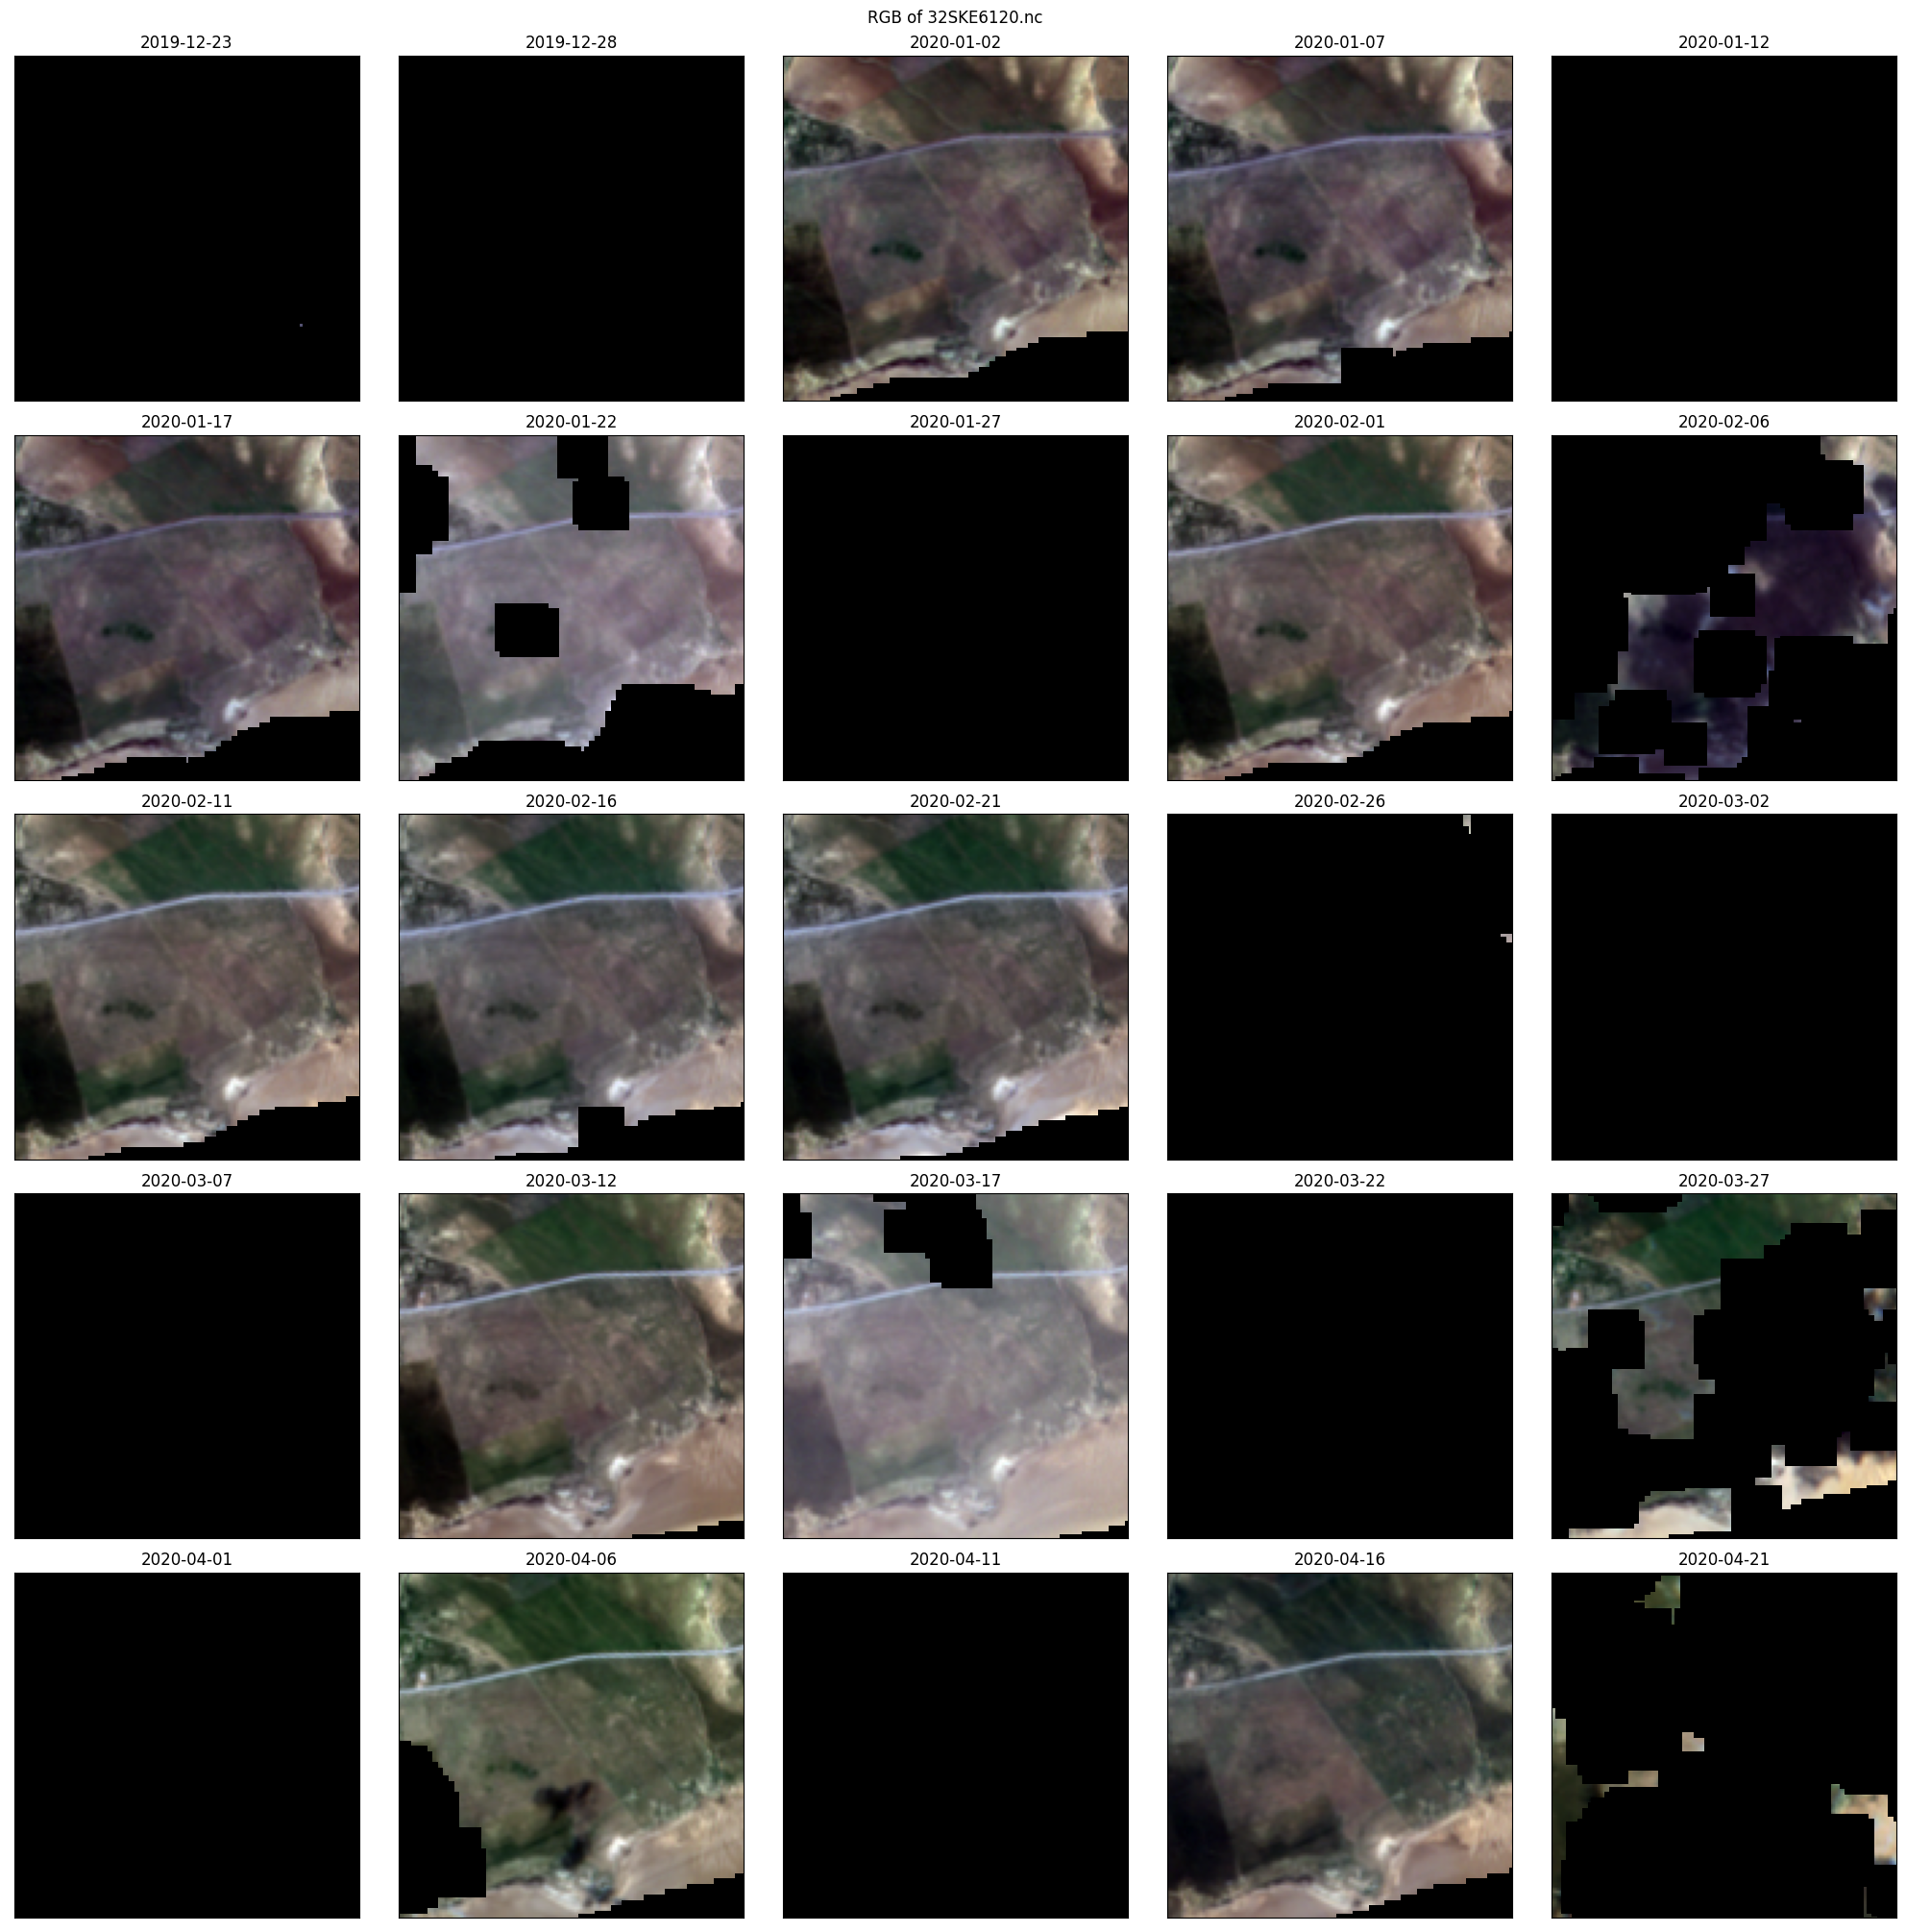

In [29]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=1
    beta=0
    return np.clip(alpha*band+beta, 0,255)

minicube = xr.open_dataset(test_path)
time = np.where(minicube.s2_avail.values == 1)[0]
mask = (minicube.s2_mask < 1.0)


fig, axes = plt.subplots(nrows=5, ncols=5, constrained_layout=True, figsize=(20, 20))
fig.suptitle("RGB of " + name)
t= 4 + 60*5 
for i in range(5):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)

        red = brighten(normalize(minicube.isel(time=t).s2_B04))
        green = brighten(normalize(minicube.isel(time=t).s2_B03))
        blue = brighten(normalize(minicube.isel(time=t).s2_B02))

        red = np.where(red * mask.isel(time=t) == 0, np.nan, red)
        green = np.where(green * mask.isel(time=t) == 0, np.nan, green)
        blue = np.where(blue * mask.isel(time=t) == 0, np.nan, blue)

        rgb_composite= np.dstack((red, green, blue))
        axes[i,j].imshow(rgb_composite)
        t += 5


Mask

In [ ]:
minicube = xr.open_dataset(test_path)
targ = minicube.s2_mask < 1
lc = minicube.esawc_lc
lc_mask = (lc <= 40) | (lc >= 90)
mask = targ * lc_mask

cmap = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])


fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
fig.suptitle("mask of " + name)
t= 4 + 40*5
for i in range(5):
    for j in range(5):
        #axes[i,j].set_aspect(1)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
        im = axes[i,j].imshow(mask.isel(time=t), vmin=0, vmax=1)
        t += 5 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


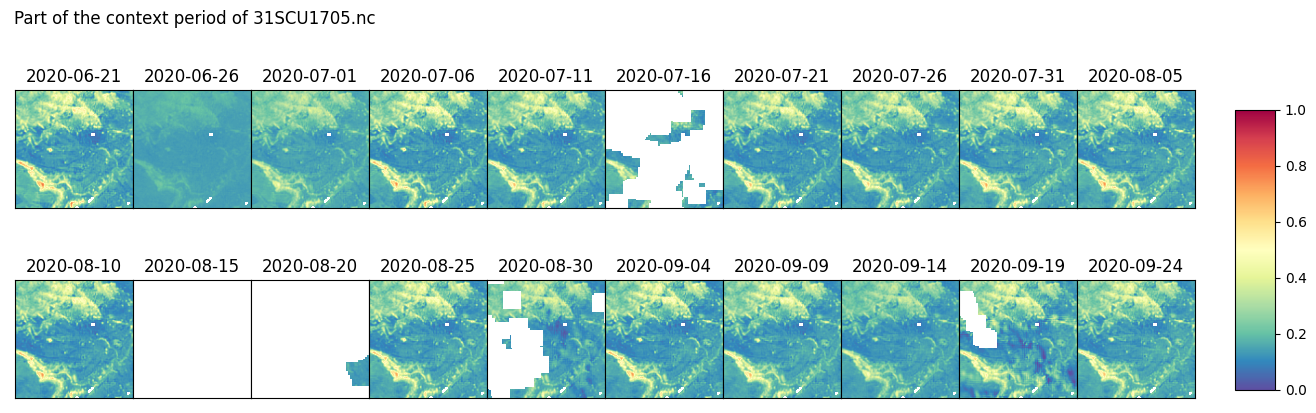

In [6]:
minicube = xr.open_dataset(test_path)
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )

mask = (minicube.s2_mask < 1.0)
lc = minicube.esawc_lc
lc_mask = (lc <= 40) | (lc >= 90)
targ = targ * mask * lc_mask
targ = np.where(targ == 0, np.nan, targ)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
fig.suptitle("Part of the context period of " + name,x=0.1, y=1.1)
t= 4 + (60 - 20) * 5
for i in range(2):
    for j in range(10):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
        im = axes[i,j].imshow(targ[t,...], cmap="Spectral_r", vmin=0, vmax=1)
        t += 5 # non gap filled, a lot of nan values

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0, top=0.99, right=0.6)
cbar_ax = fig.add_axes([0.62, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [43]:
pred_path = pred_paths[15]
print(pred_path)
name = str(pred_path)[-12:]
test_path = list(basepath.glob("test/*/" + name))[0]
print(test_path)

/Net/Groups/BGI/scratch/crobin/PythonProjects/EarthNet/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_interpolation_anomalie/preds/iid/Algeria/31SEV5535.nc
/scratch/crobin/earthnet2023_interpolated/test/Algeria/31SEV5535.nc


/Net/Groups/BGI/scratch/crobin/miniconda3/envs/EarthnetEnv/lib/python3.10/site-packages/matplotlib/cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


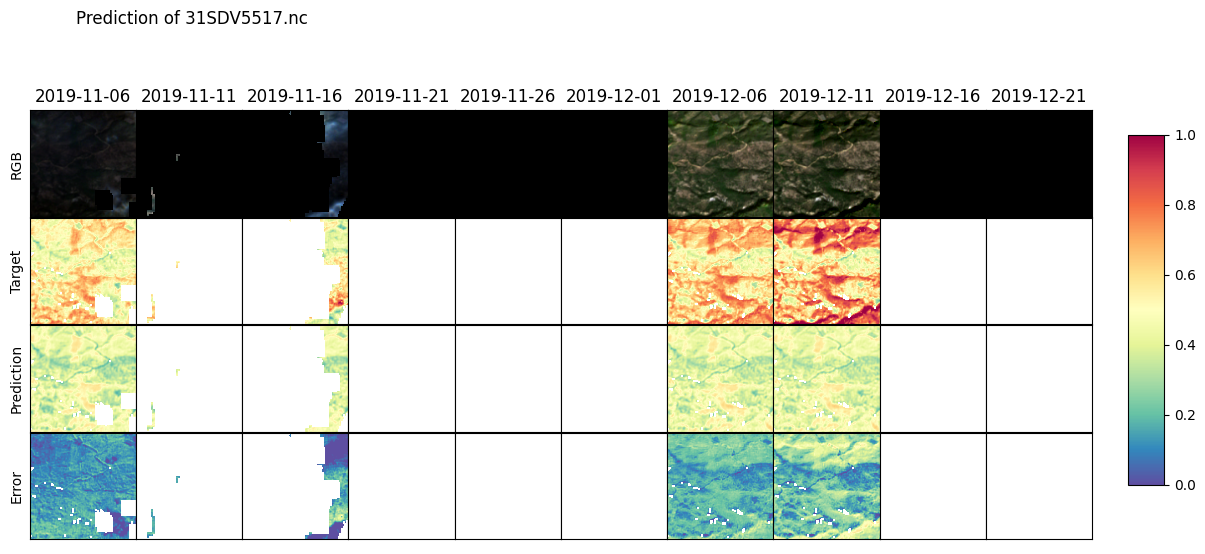

In [32]:
minicube = xr.open_dataset(test_path)
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )

mask = (minicube.s2_mask < 1.0)
lc = minicube.esawc_lc
lc_mask = (lc <= 40) | (lc >= 90)
targ = targ * mask * lc_mask
targ = np.where(targ == 0, np.nan, targ)

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(18, 5))
fig.suptitle("Prediction of " + name,x=0.1, y=1.1)

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=1
    beta=0
    return np.clip(alpha*band+beta, 0,255)

# Context
# t= 4 + 50 * 5
# i = 0
# for j in range(10):
#     axes[i,j].get_xaxis().set_visible(False)
#     axes[i,j].get_yaxis().set_visible(False)
#     axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
#     im = axes[i,j].imshow(targ[t,...], cmap="Spectral_r", vmin=0, vmax=1)
#     t += 5 # non gap filled, a lot of nan values
# axes[i,0].get_yaxis().set_visible(True)
# axes[i,0].set_ylabel('Context')
# axes[i,0].tick_params(left=False, labelleft=False)
# axes[i,0].yaxis.set_ticklabels([])


# Context
t= 4 + 60 * 5
i = 0
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    
    red = brighten(normalize(minicube.isel(time=t).s2_B04))
    green = brighten(normalize(minicube.isel(time=t).s2_B03))
    blue = brighten(normalize(minicube.isel(time=t).s2_B02))

    red = np.where(red * mask.isel(time=t) == 0, np.nan, red)
    green = np.where(green * mask.isel(time=t) == 0, np.nan, green)
    blue = np.where(blue * mask.isel(time=t) == 0, np.nan, blue)

    rgb_composite= np.dstack((red, green, blue))
    axes[i,j].imshow(rgb_composite)
        
    t += 5 
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('RGB')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

# Target
t= 4 + 60 * 5
i = 1
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    # axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    im = axes[i,j].imshow(targ[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 5 # non gap filled, a lot of nan values
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Target')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

# Prediction
pred_cube = xr.open_dataset(pred_path)
pred_cube = pred_cube * mask * lc_mask
pred = np.where(pred_cube.ndvi_pred == 0, np.nan, pred_cube.ndvi_pred)
i = 2
t = 0
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    im = axes[i,j].imshow(pred[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 1
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Prediction')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

i = 3
t1 = 4 + 60 * 5
t2 = 0  
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    error = targ[t1,...] - pred[t2,...] 
    im = axes[i,j].imshow(error, cmap="Spectral_r", vmin=0, vmax=1)
    t1 += 5
    t2 += 1
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Error')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0, top=0.9, right=0.6)
cbar_ax = fig.add_axes([0.62, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

/Net/Groups/BGI/scratch/crobin/miniconda3/envs/EarthnetEnv/lib/python3.10/site-packages/matplotlib/cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


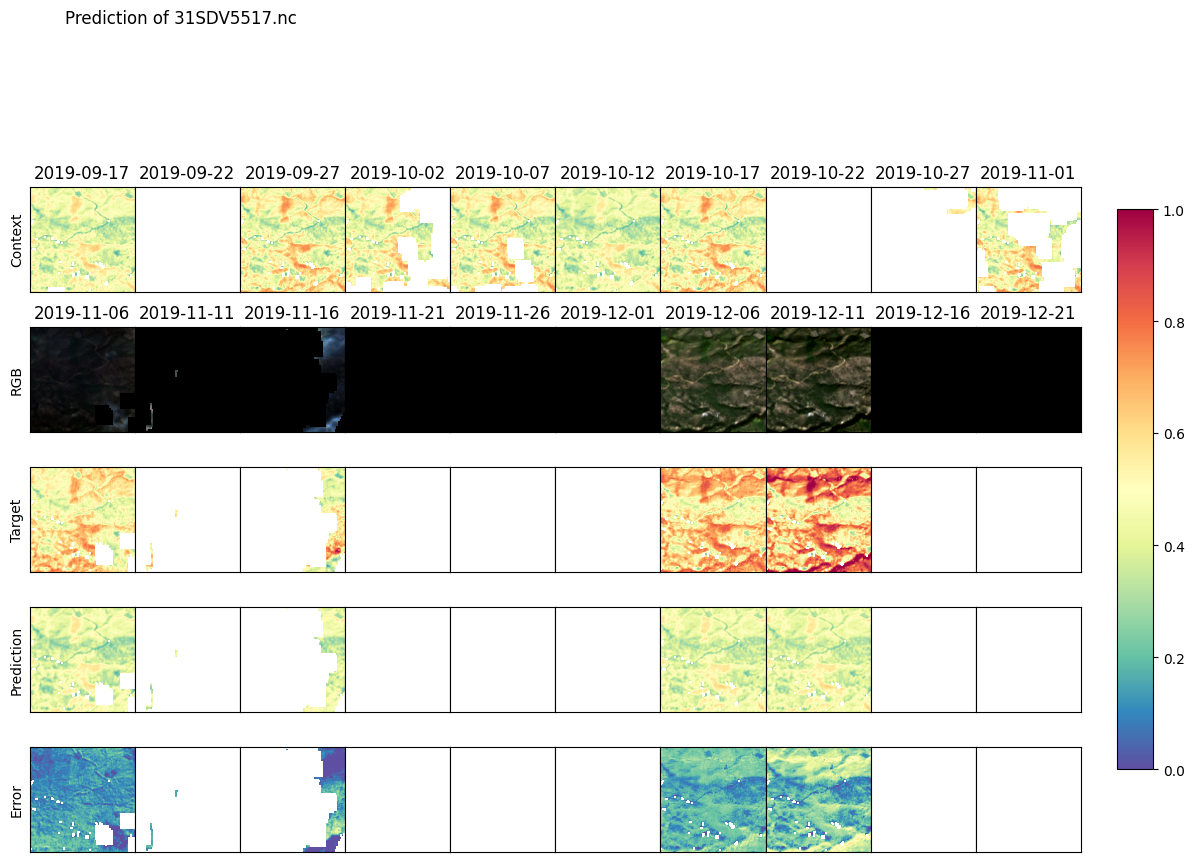

In [36]:
minicube = xr.open_dataset(test_path)
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )

mask = (minicube.s2_mask < 1.0)
lc = minicube.esawc_lc
lc_mask = (lc <= 40) | (lc >= 90)
targ = targ * mask * lc_mask
targ = np.where(targ == 0, np.nan, targ)

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(18, 8))
fig.suptitle("Prediction of " + name,x=0.1, y=1.1)

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=1
    beta=0
    return np.clip(alpha*band+beta, 0,255)

# Context
t= 4 + 50 * 5
i = 0
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    im = axes[i,j].imshow(targ[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 5 # non gap filled, a lot of nan values
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Context')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])


# Context
t= 4 + 60 * 5
i = 1
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    
    red = brighten(normalize(minicube.isel(time=t).s2_B04))
    green = brighten(normalize(minicube.isel(time=t).s2_B03))
    blue = brighten(normalize(minicube.isel(time=t).s2_B02))

    red = np.where(red * mask.isel(time=t) == 0, np.nan, red)
    green = np.where(green * mask.isel(time=t) == 0, np.nan, green)
    blue = np.where(blue * mask.isel(time=t) == 0, np.nan, blue)

    rgb_composite= np.dstack((red, green, blue))
    axes[i,j].imshow(rgb_composite)
        
    t += 5 
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('RGB')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

# Target
t= 4 + 60 * 5
i = 2
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    # axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
    im = axes[i,j].imshow(targ[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 5 # non gap filled, a lot of nan values
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Target')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

# Prediction
pred_cube = xr.open_dataset(pred_path)
pred_cube = pred_cube * mask * lc_mask
pred = np.where(pred_cube.ndvi_pred == 0, np.nan, pred_cube.ndvi_pred)
i = 3
t = 0
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    im = axes[i,j].imshow(pred[t,...], cmap="Spectral_r", vmin=0, vmax=1)
    t += 1
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Prediction')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

i = 4
t1 = 4 + 60 * 5
t2 = 0  
for j in range(10):
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    error = targ[t1,...] - pred[t2,...] 
    im = axes[i,j].imshow(error, cmap="Spectral_r", vmin=0, vmax=1)
    t1 += 5
    t2 += 1
axes[i,0].get_yaxis().set_visible(True)
axes[i,0].set_ylabel('Error')
axes[i,0].tick_params(left=False, labelleft=False)
axes[i,0].yaxis.set_ticklabels([])

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0, top=0.9, right=0.6)
cbar_ax = fig.add_axes([0.62, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

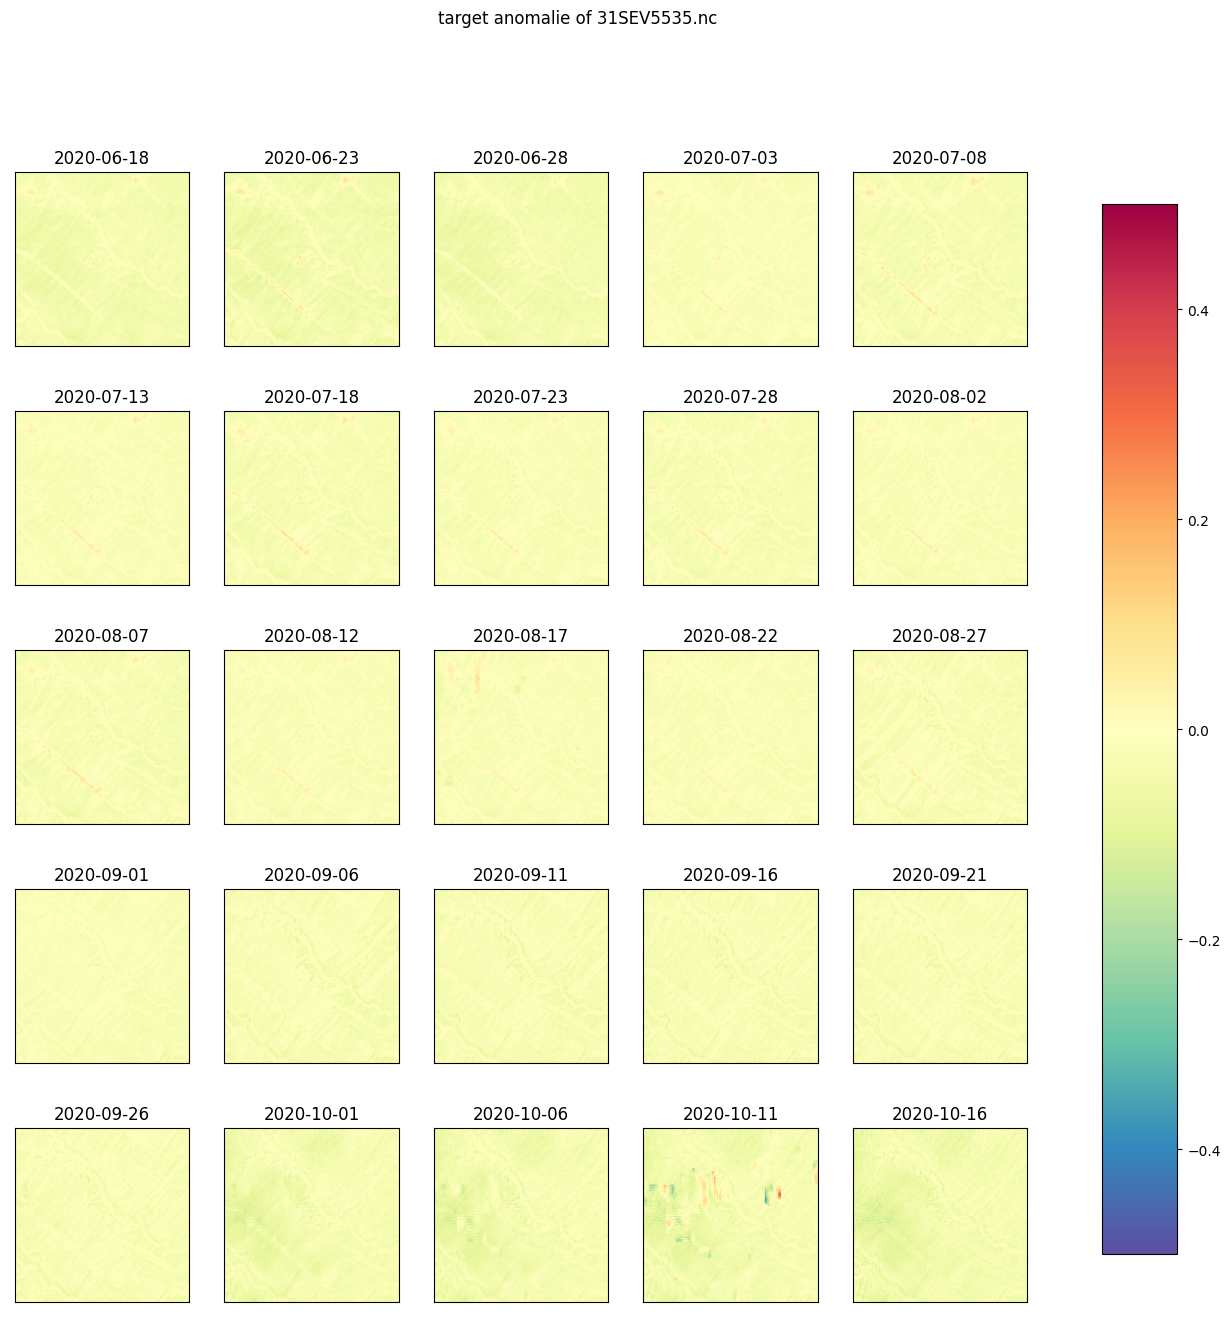

In [46]:
minicube = xr.open_dataset(test_path)
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
for i in range(1, 13):
    indices = targ.groupby("time.month").groups[i]
    index_month = minicube.ndviclim_mean.groupby("time_clim.month").groups[
        i
    ]
    targ[indices] = (
        targ[indices].values - minicube.ndviclim_mean[index_month].values
    )

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
fig.suptitle("target anomalie of " + name)
t= 4 + 40 * 5
for i in range(5):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
        im = axes[i,j].imshow(targ.isel(time=t), cmap="Spectral_r", vmin=-0.5, vmax=0.5)
        #im = targ.isel(time=time[t]).plot(cmap=cmap_veg, ax=axes[i,j])
        t += 5 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

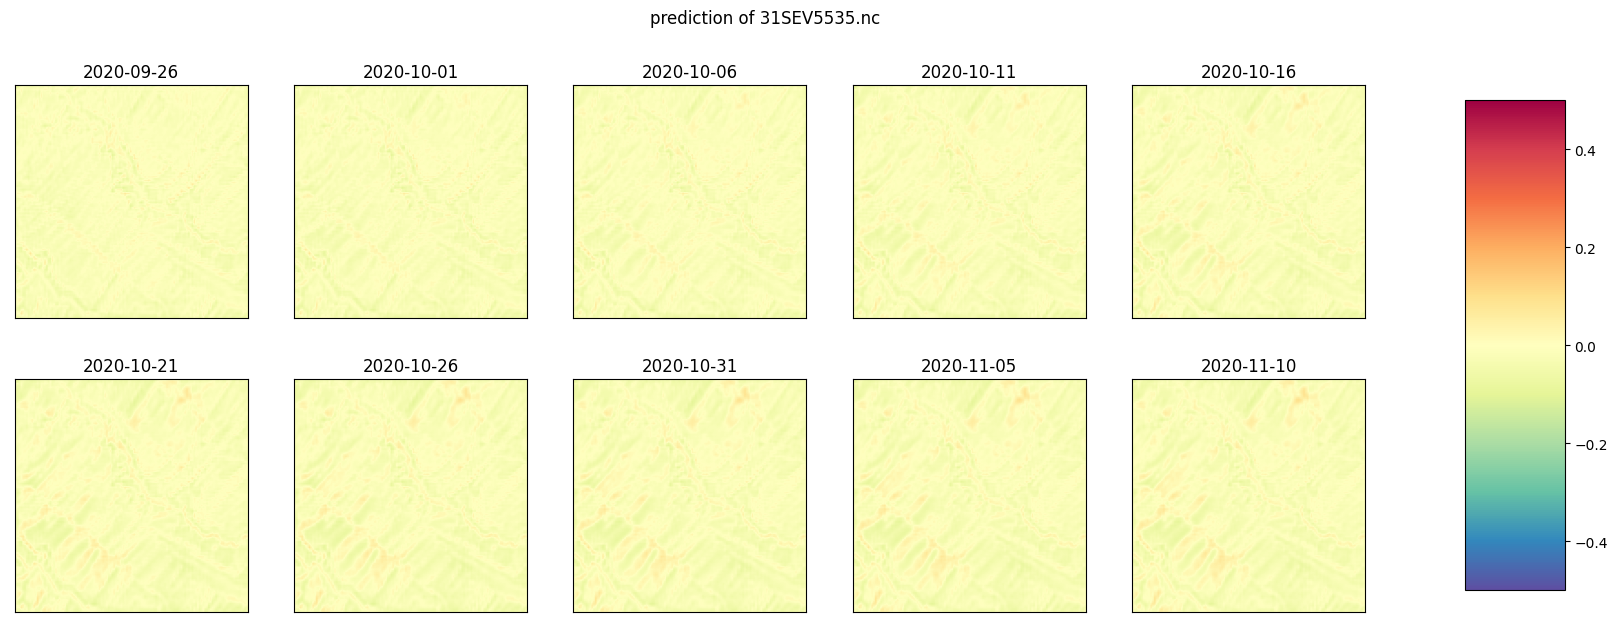

In [45]:
minicube = xr.open_dataset(pred_path)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))
fig.suptitle("prediction of " + name)
t= 0
for i in range(2):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
        im = axes[i,j].imshow(minicube.ndvi_pred.isel(time=t), cmap="Spectral_r", vmin=-0.5, vmax=0.5)
        #im = targ.isel(time=time[t]).plot(cmap=cmap_veg, ax=axes[i,j])
        t += 1 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

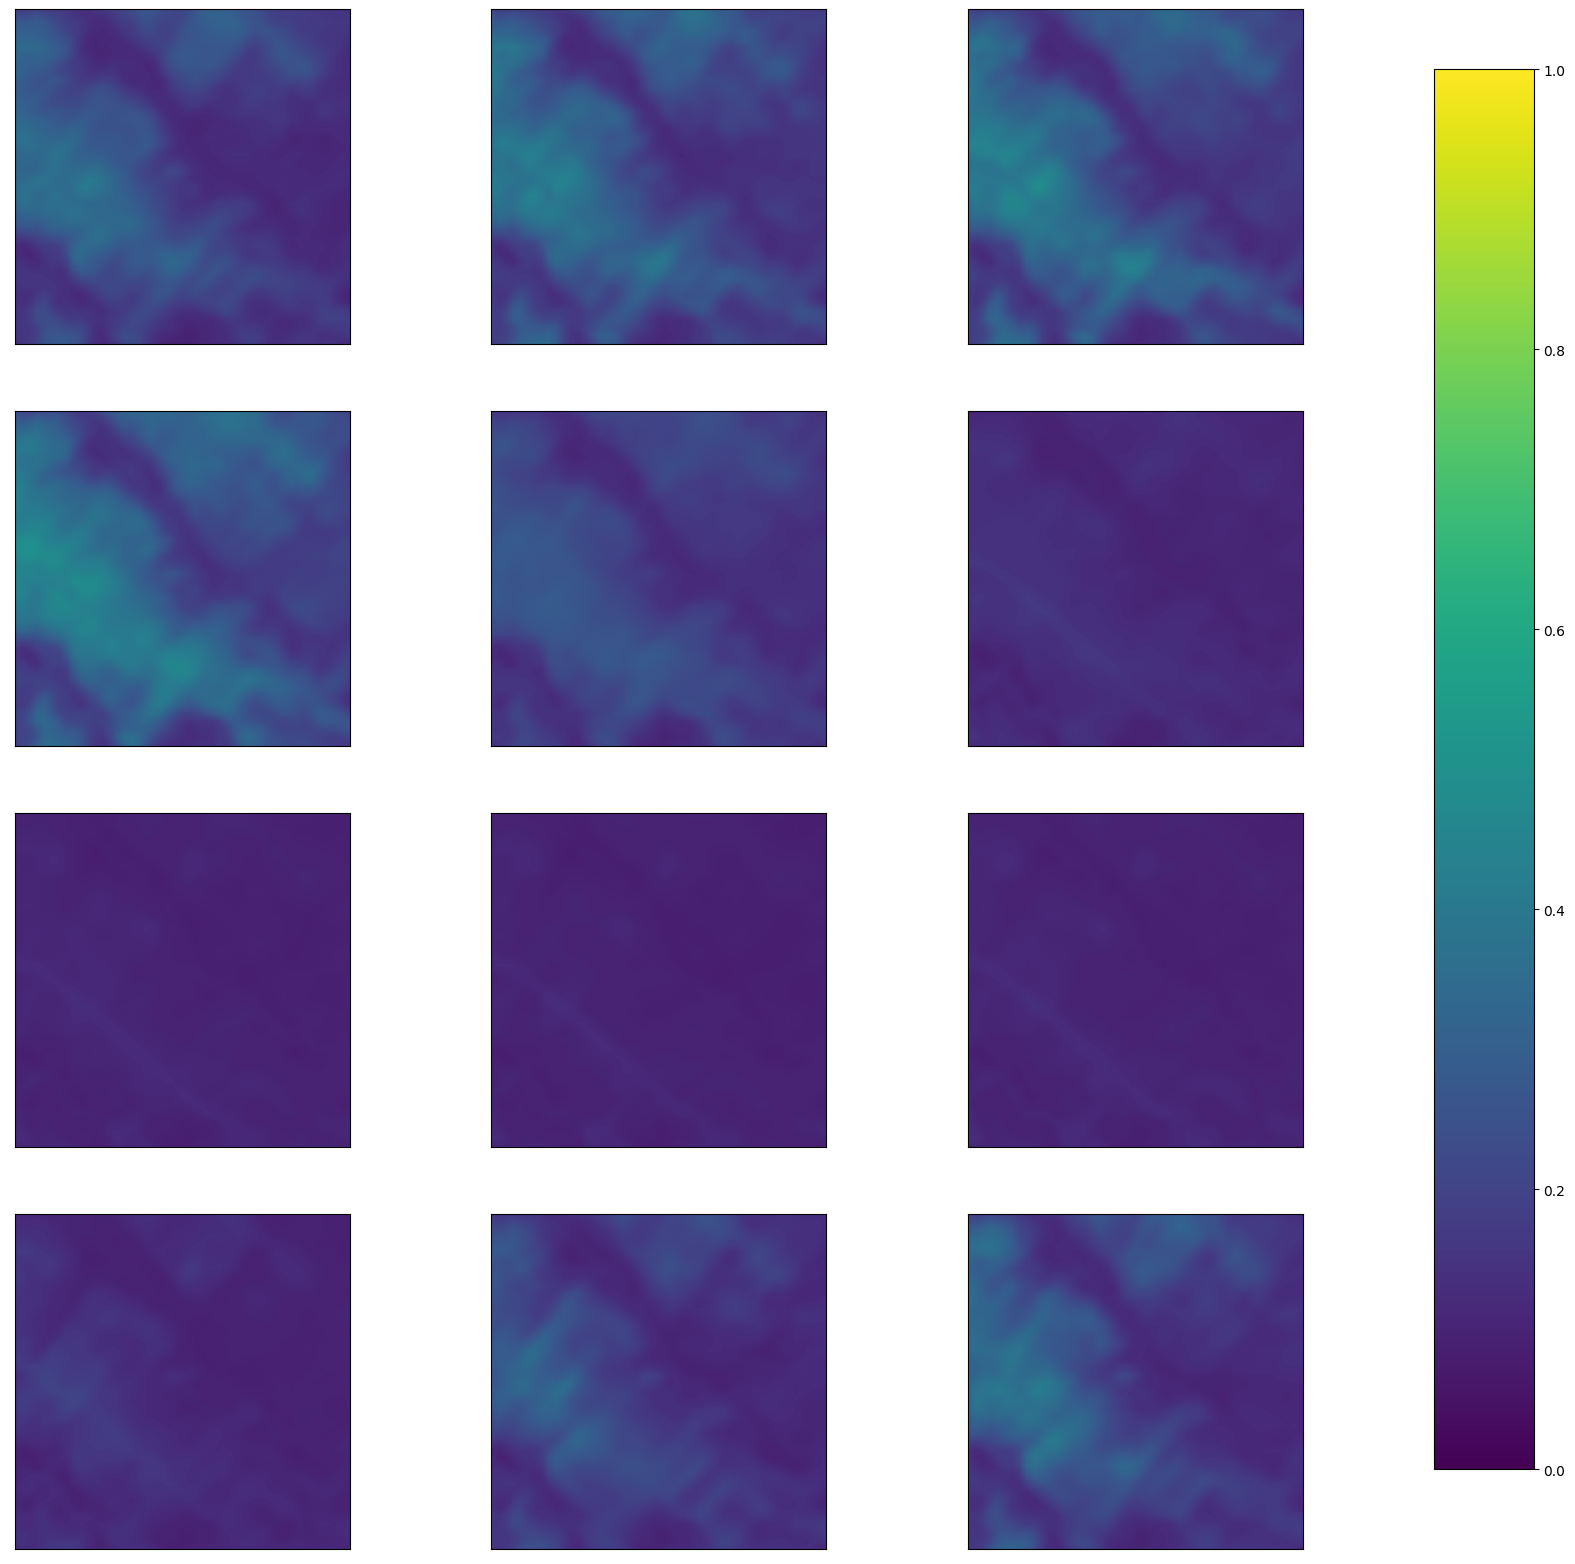

In [44]:
import matplotlib.pyplot as plt
minicube = xr.open_dataset(test_path)
data = minicube.ndviclim_mean

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
t= 0
for i in range(4):
    for j in range(3):
        #axes[i,j].set_aspect(1)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        im = axes[i,j].imshow(data.isel(time_clim=t), vmin=0, vmax=1)
        #im = targ.isel(time=time[t]).plot(cmap=cmap_veg, ax=axes[i,j])
        t += 1 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [ ]:
for i in range(1, 13):
    indices = targ.groupby("time.month").groups[i]
    index_month = minicube.ndviclim_mean.groupby("time_clim.month").groups[
        i
    ]
    targ[indices] = (
        targ[indices].values - minicube.ndviclim_mean[index_month].values
    )

In [5]:
ndvi = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
print(ndvi.groupby('time.month') - minicube.ndviclim_mean)
def anomalies(ndvi, ndvi_mean):
    print(ndvi.groupby('time.month'))
    func = lambda ndvi, ndvi_mean: ndvi.groupby('time.month').map() - ndvi_mean
    return xr.apply_ufunc(func, ndvi, ndvi_mean)

#anomalies(ndvi, minicube.ndviclim_mean)


ValueError: incompatible dimensions for a grouped binary operation: the group variable 'month' is not a dimension on the other argument

In [11]:
import datetime
print(ndvi.shape)
print(ndvi.groupby('time.month').mean('time').shape, ndvi.groupby('time.month').mean('time').dims)
a = ndvi.groupby('time.month') - ndvi.groupby('time.month').mean('time')
print(a.shape)
print(minicube.ndviclim_mean.groupby('time_clim.month'), minicube.ndviclim_mean.groupby('time_clim.month').mean('time_clim').dims)
mini2 = minicube.ndviclim_mean.groupby('time_clim.month')
print(mini2.dims)
print(ndvi.groupby('time.month').dims)
b = ndvi.groupby('time.month') - mini2
print(b.shape)


(2191, 128, 128)
(12, 128, 128) ('month', 'lat', 'lon')
(2191, 128, 128)
DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12. ('month', 'lat', 'lon')
('time_clim', 'lat', 'lon')
('time', 'lat', 'lon')


TypeError: GroupBy objects only support binary ops when the other argument is a Dataset or DataArray